# Initialization

In [1]:
from lmfit import models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Customized code

In [55]:
from operator import add
from functools import reduce

def read_xps_data_from_excel(file, sheet_name, skiprows=7):
    raw = pd.read_excel(file, sheet_name=sheet_name, skiprows=skiprows)

    try:
        new = pd.DataFrame()
        new['BindingEnergy'] = raw['B. E.']
        new['Counts'] = raw['Counts']
        new['FitRegion_BindingEnergy'] = raw['PkGrp1_BE']
        new['FitBackground'] = raw['PkGrp1_Count']
        new['FitEnvelope'] = raw['PkFitEnv1']
        
        #Search for variable number of peaks
        peaki = 1
        while True:
            try:
                new['Peak{}'.format(peaki)] = raw['Pk0{}'.format(peaki)]
                peaki += 1
            except KeyError:
                break
    except KeyError:
        print('File does not match peak finding pattern Pk01, Pk02, ..., returning raw columns')
        new = pd.DataFrame()
        new['BindingEnergy'] = raw['B. E.']
        new['Counts'] = raw['Counts']
        for k in raw.keys():
            if k != 'B. E.' and k != 'Count':
                new[k] = raw[k]
    return new

def plot_xps_data_matplotlib(xpsdataframe):
    plt.plot(xpsdataframe['BindingEnergy'], xpsdataframe['Counts'], label='AllData')
    
    x = xpsdataframe['FitRegion_BindingEnergy']
    for k in xpsdataframe.keys()[3:]:
        plt.plot(x, xpsdataframe[k], label=k)
        
    plt.legend()
    plt.show()

def take_energy_range(energies, data, erange):
    indices = (energies >= erange[0]) & (energies <= erange[1])
    return np.array([energies[indices], data[indices]])

def get_background_subtracted_data(xpsdataframe):
    croppednans = xpsdataframe['FitRegion_BindingEnergy'][pd.notna(xpsdataframe['FitRegion_BindingEnergy'])]
    upper = croppednans.iloc[0]
    lower = croppednans.iloc[-1]
    energies, data = take_energy_range(xpsdataframe['BindingEnergy'], xpsdataframe['Counts'], [lower, upper])
    assert (energies - croppednans < 1e-10).all(), 'Energy grid of BindingEnergy and FitRegion_BindingEnergy did not match'
    new = {}
    new['BindingEnergy'] = energies
    new['Counts'] = data - xpsdataframe['FitBackground'][pd.notna(xpsdataframe['FitBackground'])]
    return pd.DataFrame(new)

def doublet_peakshape_model(mainpeakpos=120, gamma=0.15, sigma=0.35, splitting=-0.8, ratio=2, prefix='a'):
    """Makes lmfit model of doublet shape.
    
    Model is composed of two voigts with fixed Lorentzian
     and Gaussian widths and fixed splitting and peak ratios.

    Args:
        mainpeakpos: Energy (eV) position of main peak.
        gamma: Lorentzian width (in voigt model).
        sigma: Gaussian width (in voigt model).
        splitting: Energy gap (eV) between the two components
        ratio: Ratio of peak heights a1/a2

    Returns:
        lmfit model, lmfit pars

    Raises:
        Nothing.
    """
    prefix1 = prefix + '1_'
    prefix2 = prefix + '2_'
    mod = models.VoigtModel(prefix=prefix1)+models.VoigtModel(prefix=prefix2)
    pars = mod.make_params()
    parsdict = dict([[prefix2+'amplitude',{'expr': prefix1+'amplitude*'+str(1/ratio), 'value': 1/ratio, 'vary': False}],
                     [prefix2+'gamma', {'expr': prefix1+'gamma', 'value': gamma, 'vary': False}],
                     [prefix2+'center', {'expr': prefix1+'center-'+str(splitting), 'value': mainpeakpos-splitting, 'vary': False}],
                     [prefix1+'sigma', {'expr': '', 'value': sigma, 'vary': False}],
                     [prefix1+'gamma', {'expr': '', 'value': gamma, 'vary': False}],
                     [prefix1+'center', {'expr': '', 'value': mainpeakpos, 'vary': True}],
                     [prefix2+'sigma', {'expr': prefix1+'sigma', 'value': sigma, 'vary': False}]])
    for k,v in parsdict.items():
        pars[k].set(vary=v['vary'],expr=v['expr'])
    for k,v in parsdict.items():
        pars[k].value=v['value']
    return mod, pars

def multiple_doublet_model(centralenergies, relativeintensities):
    assert len(centralenergies) == len(relativeintensities), 'Intensities and energies must have same length.'
    models = []
    parslist = []
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    for i in range(len(centralenergies)):
        mod, pars = doublet_peakshape_model(centralenergies[i], prefix=alphabet[i])
        pars[alphabet[i]+'1_amplitude'].set(value=relativeintensities[i])
        models.append(mod)
        parslist.append(pars)
    totalmodel = reduce(add, models)
    totalpars = reduce(add, parslist)
    return totalmodel, totalpars

def xps_fit(xpsdataframe, centralenergies, relativeintensities):
    bgsub = get_background_subtracted_data(xpsdataframe)
    energies = bgsub['BindingEnergy']
    data = bgsub['Counts']
    mod, pars = multiple_doublet_model(centralenergies, relativeintensities)
    for k in pars.keys():
        if '1_amplitude' in k:
            pars[k].set(value=data.max() * pars[k].value)
    fit = mod.fit(data, params=pars, x=energies)
    return fit, mod, pars

def plot_xps_fit(fit, showallcomponents=False):
    x = fit.userkws['x']
    plt.plot(x, fit.data, label='Data')
    plt.plot(x, fit.eval(x=x), label='Fit')
    components = fit.eval_components(x=x)
    
    uniqueprefixes = sorted(list(set([s[:-2] for s in components.keys()])))
    for p in uniqueprefixes:
        plt.plot(x, components[p+'1_'] + components[p+'2_'], label=p)
        
    if showallcomponents:
        for k, v in components.items():
            plt.plot(x, v, 'k--', alpha=0.5)
        
    plt.legend()
    plt.xlabel('Binding Energy')
    ax = plt.gca()
    ax.invert_xaxis()
    plt.ylabel('Intensity')
    plt.show()

def calculate_component_percentages(fit):
    components = fit.eval_components()
    uniqueprefixes = sorted(list(set([s[:-2] for s in components.keys()])))
    intensities = {}
    for p in uniqueprefixes:
        intensities[p] = np.sum(components[p+'1_'] + components[p+'2_'])
    total = np.sum(list(intensities.values()))
    for k, v in intensities.items():
        intensities[k] = v / total
    return intensities

# Example usage

## import data using pandas

Import data from Excel file and specific sheet

In [4]:
data = read_xps_data_from_excel('CHC-049.xlsx', sheet_name='Sheet9', skiprows=8)

Plot the data to view it:

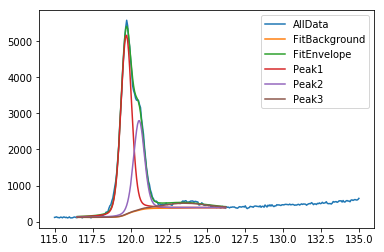

In [6]:
plot_xps_data_matplotlib(data)

## fit data using LMFIT

Fit the data using a list of energies for oxidation state components and a list of their relative intensities.

For example:

centralenergies = (120.0, 123.0, 124.0)

relativeintensities = (1, 0.1, 0.25)

In [68]:
fitoutput, model, parameters = xps_fit(data, [120.0, 123.0, 124.0], [1, 0.1, 0.25])

Plot the fit results.  Individual components are labelled by letter in order of the supplied centralenergies list.

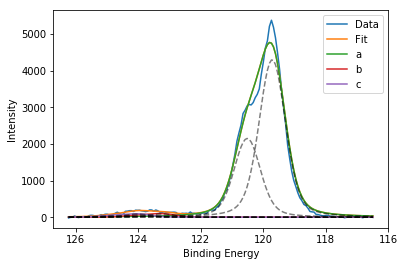

In [69]:
plot_xps_fit(fitoutput, showallcomponents=True)

Then we can calculate the relative proportions of the components.  The area of each peak is divided by the sum of all of the components:

In [70]:
calculate_component_percentages(fitoutput)

{'a': 0.9609814146148465, 'b': 0.02013736443405898, 'c': 0.018881220951094537}

Then feel free to look at the full fit report:

In [61]:
print(fitoutput.fit_report())

[[Model]]
    (((Model(voigt, prefix='a1_') + Model(voigt, prefix='a2_')) + (Model(voigt, prefix='b1_') + Model(voigt, prefix='b2_'))) + (Model(voigt, prefix='c1_') + Model(voigt, prefix='c2_')))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 106
    # data points      = 162
    # variables        = 6
    chi-square         = 1552996.78
    reduced chi-square = 9955.10755
    Akaike info crit   = 1497.23231
    Bayesian info crit = 1515.75789
[[Variables]]
    a1_sigma:      0.35 (fixed)
    a1_center:     120.141805 +/- 0.00314947 (0.00%) (init = 120)
    a1_amplitude:  7153.90424 +/- 26.7497559 (0.37%) (init = 6533)
    a2_sigma:      0.35000000 +/- 0.00000000 (0.00%) == 'a1_sigma'
    a2_center:     120.941805 +/- 0.00314947 (0.00%) == 'a1_center--0.8'
    a2_amplitude:  3576.95212 +/- 13.3748779 (0.37%) == 'a1_amplitude*0.5'
    a1_gamma:      0.15 (fixed)
    a1_fwhm:       0.99630264 +/- 0.00000000 (0.00%) == '1.0692*a1_gamma+sqrt(0.8664*a1_gamma**2+

## To customize fitting constraints

Take the model and parameters from the previous output, then adjust individual parameters as necessary in the fit output to then perform a new fit:

In [71]:
for k, v in fitoutput.params.items():
    if 'gamma' in k:
        v.set(expr='a1_gamma')
    if 'sigma' in k:
        v.set(expr='a1_sigma')
        
fitoutput.params['a1_gamma'].set(vary=True)
fitoutput.params['a1_sigma'].set(vary=True)

In [72]:
# I also tried changing the peak ratio using the following, but decided it was unnecessary

# newratio = 2.2
# for k, v in fitoutput.params.items():
#     if '2_amplitude' in k:
#         v.set(expr='{} * {}'.format(k[0]+'1_amplitude', 1/newratio))

Then re-run the fit as follows:

In [73]:
fitoutput.fit()

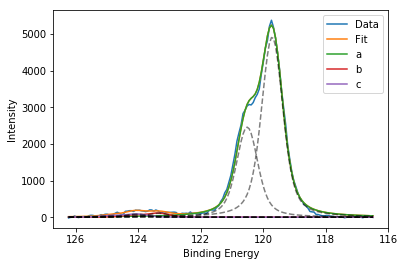

In [74]:
plot_xps_fit(fitoutput, showallcomponents=True)

In [75]:
calculate_component_percentages(fitoutput)

{'a': 0.962650359385361, 'b': 0.02115608436019751, 'c': 0.0161935562544415}

In [76]:
fitoutput.best_values

{'c2_sigma': 0.24997301400313487,
 'c2_center': 124.86419407632083,
 'c2_amplitude': 43.30688207301374,
 'c2_gamma': 0.18278726142412846,
 'c1_sigma': 0.24997301400313487,
 'c1_center': 124.06419407632083,
 'c1_amplitude': 86.61376414602748,
 'c1_gamma': 0.18278726142412846,
 'b2_sigma': 0.24997301400313487,
 'b2_center': 124.14462743222603,
 'b2_amplitude': 56.07209596119116,
 'b2_gamma': 0.18278726142412846,
 'b1_sigma': 0.24997301400313487,
 'b1_center': 123.34462743222603,
 'b1_amplitude': 112.14419192238232,
 'b1_gamma': 0.18278726142412846,
 'a2_sigma': 0.24997301400313487,
 'a2_center': 120.51639990576483,
 'a2_amplitude': 2539.1103758019085,
 'a2_gamma': 0.18278726142412846,
 'a1_sigma': 0.24997301400313487,
 'a1_center': 119.71639990576483,
 'a1_amplitude': 5078.220751603817,
 'a1_gamma': 0.18278726142412846}

In [64]:
fitoutput.params.pretty_print()

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
a1_amplitude      5078     -inf      inf       35     True     None     None
a1_center        119.7     -inf      inf 0.002628     True     None     None
a1_fwhm         0.8082     -inf      inf 0.007095    False 1.0692*a1_gamma+sqrt(0.8664*a1_gamma**2+5.545083*a1_sigma**2)     None
a1_gamma        0.1828     -inf      inf 0.008305     True     None     None
a1_height         4920     -inf      inf    32.23    False (a1_amplitude/(a1_sigma*sqrt(2*pi)))*wofz((1j*a1_gamma)/(a1_sigma*sqrt(2))).real     None
a1_sigma          0.25        0      inf 0.006532     True     None     None
a2_amplitude      2539     -inf      inf     17.5    False a1_amplitude*0.5     None
a2_center        120.5     -inf      inf 0.002628    False a1_center--0.8     None
a2_fwhm         0.8082     -inf      inf        0    False 1.0692*a2_gamma+sqrt(0.8664*a2_gamma**2+5.545083*a2_sigma**2)     None
a2_gamma        0.1828     -inf     